In [1]:
%load_ext autoreload
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


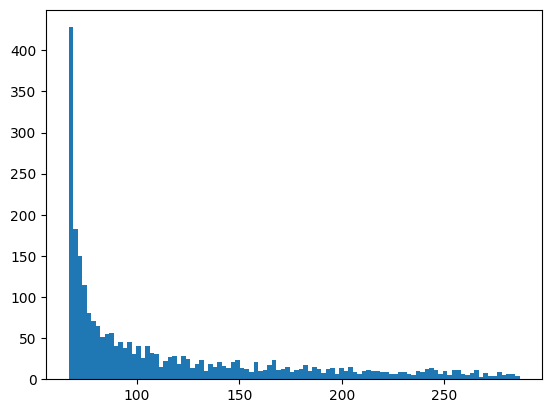

In [5]:
%autoreload 2
# 10/12/2023 - NEW (2 days of optimization) COMPUTATION WITH MASK ON GPU
%run ../src/boson_cloud_gpu/main.py